## Importing Packages

In [4]:

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load

# NLP stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from gensim.models import Word2Vec
import gensim

# LSTM machine learning stuff etc
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

## Settings

In [50]:
#SETTINGS
RANDOM_STATE = 42

#DATASET
TRAIN_SIZE = 0.8

#TEXT CLEANING REGEX 
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

In [53]:
train_ds = pd.read_csv("data/Constraint_Train.csv")
val_ds = pd.read_csv("data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds])

In [54]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [55]:
df = df.drop('id', axis=1)

In [56]:
df.shape

(8560, 2)

In [57]:
df.label.unique()

array(['real', 'fake'], dtype=object)

## Checking for Null Inputs

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8560 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   8560 non-null   object
 1   label   8560 non-null   object
dtypes: object(2)
memory usage: 200.6+ KB


## Label Distribution

In [59]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

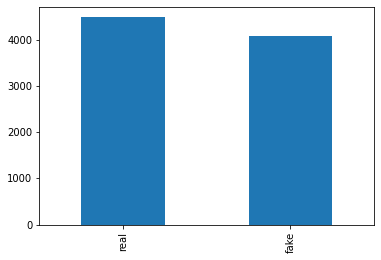

In [60]:
df.label.value_counts().plot(kind='bar')

In [61]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [62]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

## Previewing Tweets

In [63]:
print(df.tweet.sample(15).values)

['Democrats to blame for Covid-19 related deaths. They control the drugs against the virus.'
 '??�If you line up all the countries that have done (Covid-19) testing on a per-capita basis, we???re at the bottom of the list.??�'
 'Metro Manila had an 83% rise in COVID-19 cases in one day.'
 "@tamazonx It's probably the reason Trump's favorite covid drug is chloroquine."
 '#IndiaFightsCorona: This pie chart shows the overall percentage of #COVID cases in three different categories. 78.28% of the total cases are Recovered/ Discharged One-fifth i.e. 20.08% of the total cases are Active 1.64% of the total cases are deaths: Secretary @MoHFW_INDIA https://t.co/D38uypIS0p'
 'Retraction—Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis - The Lancet https://t.co/L5V2x6G9or'
 "The death toll fell beneath 1000 for the first time since April 1. However we don't know how much of this is due to the weekend lag effect. Last week M

Processing:
- remove hyperlinks
- only allow alpha-numeric characters

In [64]:

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return " ".join(tokens)

In [65]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [66]:
print(df.tweet.sample(15).values)

['gammon guid fli age covid 19'
 'photo funer recent deceas sri lankan politician arumugam thondaman share thousand time multipl facebook post post claim imag show one thondaman daughter violat sri lanka mandatori coronavirus quarantin polici travel attend ceremoni short return countri oversea'
 'week jdmaresco careeningspac took data engin room covid19track made process reliabl easier manag offici 2 week old contribut vital'
 'paul manafort releas prison home confin amid coronavirus concern manafort'
 'coronavirusupd covid19 india tracker 19 septemb 2020 08 00 confirm case 5308014 recov 4208431 79 3 activ case 1013964 19 1 death 85619 1 6 indiafightscorona indiawillwin staysaf via mohfw india'
 'suppli increas next stage vaccin rollout would expand base assess countri vulner virus drtedro covid19'
 'rt surgeon general dyk cloth face cover may help prevent peopl covid19 know exper'
 'viral video interview tierra pura portal dissemin doctor mariana colombr garmendia denounc overregistr 

## Train Test Split

In [67]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 6848
TEST size: 1712


In [68]:
df_train

,tweet,label
1729,594 new case covid19nigeria lago 159 delta 106...,real
1551,hcps today 2pm et log coca facebook profil cal...,real
3128,whole floor main peruvian hospit infect covid ...,fake
2041,cdc director robert redfield say healthi peopl...,fake
5438,covid 19 updat two new case covid 19 report ma...,real
...,...,...
5734,netflix seri secret terrius foretold pandem,fake
5191,madagascar covid 19 free april 28 regist 100 r...,fake
5390,news smoker wait pub reopen spend night stand ...,fake
860,pronxt mohfw india per goi covid19 case homeis...,real


## Word2Vec Model

In [69]:
documents = [tweet.split() for tweet in df_train.tweet]


In [71]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [72]:
w2v_model.build_vocab(documents)


In [73]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(2706752, 3823296)

In [78]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.37482425570487976),
 ('coronavirusindia', 0.36709293723106384),
 ('covidupd', 0.3512102961540222),
 ('acquir', 0.3492218255996704),
 ('admit', 0.3359830975532532),
 ('drhvoffic', 0.3348485231399536),
 ('treat', 0.3276406526565552),
 ('covid19india', 0.31679126620292664),
 ('shot', 0.3099648356437683),
 ('coronaviruspandem', 0.3092872202396393)]

## Tokenise Text

In [80]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 11020


## Padding

In [82]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen=SEQUENCE_LENGTH)

In [83]:
labels = df_train.label.unique().tolist()
labels

['real', 'fake']

## Label Encoding

In [86]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (6848, 1)
y_test (1712, 1)


In [95]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6848, 300)
y_train (6848, 1)
x_test (1712, 300)
y_test (1712, 1)


## Embedding Matrix

In [87]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11020, 300)


## TF-IDF Vectorisation

In [90]:
tfidf = tokenizer.texts_to_matrix(documents, mode='tfidf')

In [91]:
tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.45168317, 1.56646918, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 8.13885675,
        8.13885675],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [92]:
import xgboost

xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [93]:
xgb.fit(tfidf,y_train)
#xgb_pred = xgb.predict(test)
#xgb_acc = metrics.accuracy_score(y_test,hashing_xgb_pred)

#print(xgb_acc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)